In [189]:
from cirq_sic import *
import recirq

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default") 

from IPython.display import display, Math, Markdown

## Metrics as a function of n_shots

In [153]:
n_shots_list = [1000, 5000, 10000, 20000, 50000, 100000]

def calculate_sky_ground_metrics(P, p, C, q, verbose=False):
    d = int(np.sqrt(P.shape[0]))
    Phi = np.linalg.inv(P)
    q_ = C @ Phi @ p
    P_sic = SIC_P(d)
    Phi_sic = np.linalg.inv(P_sic)
    delta_P = np.linalg.norm(P - P_sic)
    delta_Phi = np.linalg.norm(Phi - Phi_sic)
    quantumness = np.linalg.norm(np.eye(d**2) - Phi)
    quantumness_sic = np.linalg.norm(np.eye(d**2) - Phi_sic)
    delta_q = np.linalg.norm(q - q_)
    if verbose:
        display(Markdown("Sky/Ground Metrics:"))
        display(Math(r'\ |P - P_{\text{SIC}}|= \ %f' % delta_P))
        display(Math(r'\ |\Phi - \Phi_{\text{SIC}}|= \ %f' % delta_Phi))
        display(Math(r'\ |I - \Phi|= \ %f' % quantumness))
        display(Math(r'\ |I - \Phi_{\text{SIC}}|= \ %f' % quantumness_sic))
        display(Math(r'\ |q - C \Phi p|= \ %f' % delta_q))
    return locals()

def get_metrics(results):
    Ps = {}
    for result in results["characterize_wh_reference_device"]:
        P = np.array(result["P"])
        if result["task"].wh_implementation == "ak":
            P = change_conjugate_convention(P)
        Ps[result["task"].n_shots] = P

    ps = {}
    for result in results["wh_povm_on_basis_states"]:
        ps[result["task"].n_shots] = np.array(result["p"])

    Cs = {}
    for result in results["basis_measurement_on_wh_states"]:
        C = np.array(result["C"])
        if result["task"].wh_implementation == "ak":
            C = change_conjugate_convention(C)
        Cs[result["task"].n_shots] = C
        
    qs = {}
    for result in results["basis_measurement_on_basis_states"]:
        qs[result["task"].n_shots] = np.array(result["q"])

    metrics = {}
    for n_shots in n_shots_list:
        metrics[n_shots] = calculate_sky_ground_metrics(Ps[n_shots], ps[n_shots], Cs[n_shots], qs[n_shots])
    
    return metrics

In [154]:
experiment_name = "sky_ground"
base_dir = f'../experiments/data/{experiment_name}'

query = {"dataset_id": "9_18_25",
         "processor_id": "willow_pink",
         "d": 4}
records = recirq.load_records(dataset_id=query["dataset_id"], base_dir=base_dir)

all_metrics = {}
for run_type in ["clean", "noisy"]:
    for wh_implementation in ["simple", "ak"]:
      results = dict([(program.description,\
                       query_records(records, {**query, "description": program.description,\
                                                        "run_type": run_type,\
                                                        "wh_implementation": wh_implementation}))\
                        for program in sky_ground_programs])
      all_metrics[(run_type, wh_implementation)] = get_metrics(results)

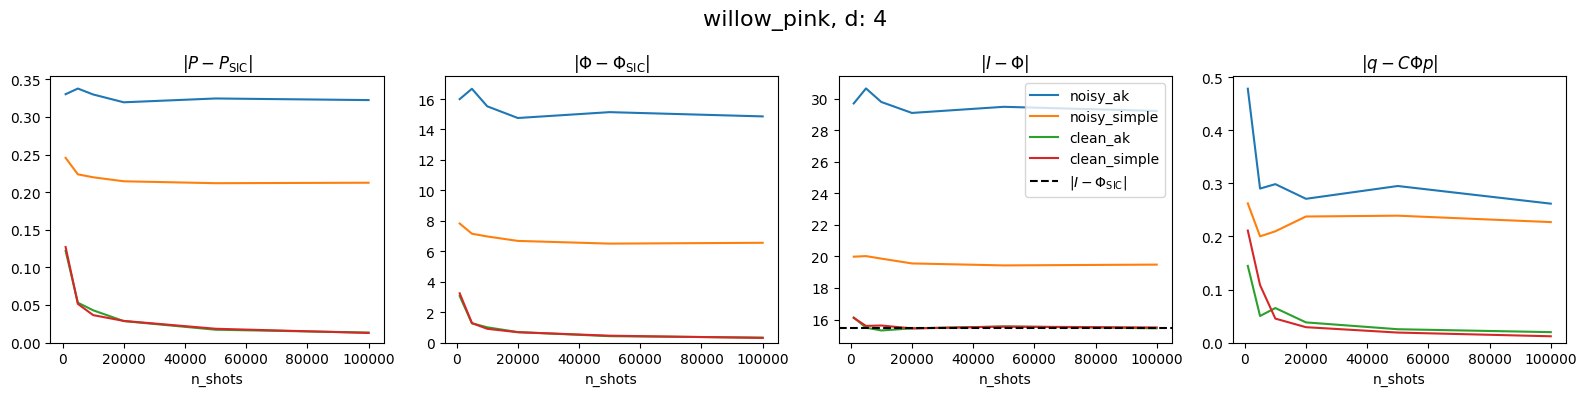

In [190]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

keys = [("noisy", "ak"),("noisy", "simple"), ("clean", "ak"), ("clean", "simple")]
for key in keys:
    metrics = all_metrics[key]
    axes[0].plot(n_shots_list, [metrics[n_shots]["delta_P"] for n_shots in n_shots_list], label="_".join(key))
    axes[1].plot(n_shots_list, [metrics[n_shots]["delta_Phi"] for n_shots in n_shots_list], label="_".join(key))
    axes[2].plot(n_shots_list, [metrics[n_shots]["quantumness"] for n_shots in n_shots_list], label="_".join(key))
    axes[3].plot(n_shots_list, [metrics[n_shots]["delta_q"] for n_shots in n_shots_list], label="_".join(key))

axes[0].set_title(r"$|P - P_{\text{SIC}}|$")
axes[0].set_ylim(bottom=0)
axes[0].set_xlabel("n_shots")

axes[1].set_title(r"$|\Phi - \Phi_{\text{SIC}}|$")
axes[1].set_ylim(bottom=0)
axes[1].set_xlabel("n_shots")

axes[2].set_title(r"$|I - \Phi|$")
axes[2].axhline(np.linalg.norm(np.eye(16) - np.linalg.inv(SIC_P(4))), color='black', linestyle='--', label=r"$|I - \Phi_{\text{SIC}}|$")
axes[2].set_xlabel("n_shots")

axes[3].set_title(r"$|q - C \Phi p|$")
axes[3].set_xlabel("n_shots")
axes[3].set_ylim(bottom=0)
#axes[0].legend()
#axes[1].legend()
axes[2].legend()
#axes[3].legend()

fig.suptitle("%s, d: %d" %  (query["processor_id"],  query["d"]), fontsize=16)
plt.tight_layout()
fig.savefig("img/metrics.pdf", bbox_inches='tight')
plt.show()

### Drilling down

In [230]:
experiment_name = "sky_ground"
base_dir = f'../experiments/data/{experiment_name}'

query = {"dataset_id": "9_18_25",
         "processor_id": "willow_pink",
         "run_type": "noisy",
         "wh_implementation": "ak",
         "n_shots": 10000,
         "d": 4}
records = recirq.load_records(dataset_id=query["dataset_id"], base_dir=base_dir)
results = dict([(program.description,\
                query_records(records, {**query, "description": program.description}))\
                      for program in sky_ground_programs])

In [231]:
P = np.array(results["characterize_wh_reference_device"][0]["P"])
p = np.array(results["wh_povm_on_basis_states"][0]["p"])
C = np.array(results["basis_measurement_on_wh_states"][0]["C"])
q = np.array(results["basis_measurement_on_basis_states"][0]["q"])

# Fix this at a more fundamental level.
if query["wh_implementation"] == "ak":
    P = change_conjugate_convention(P)
    C = change_conjugate_convention(C)

Phi = np.linalg.inv(P)
q_ = C @ Phi @ p
context_str = "%s, run_type: %s, wh_impl: %s, n_shots: %d, d: %d" % \
                    (query["processor_id"], query["run_type"], query["wh_implementation"], query["n_shots"], query["d"])
globals().update(calculate_sky_ground_metrics(P, p, C, q, verbose=True))

Sky/Ground Metrics:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## $P$ vs $P_{\text{SIC}}$

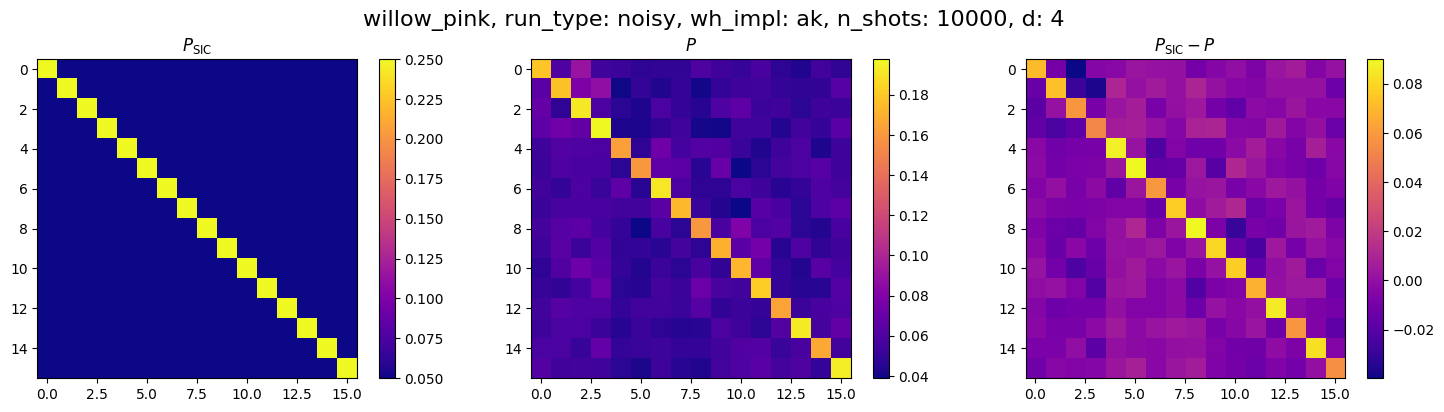

In [232]:
P_sic = SIC_P(4)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
im1 = axes[0].imshow(P_sic, cmap='plasma')
fig.colorbar(im1, ax=axes[0], label='')
axes[0].set_title(r'$P_{\text{SIC}}$')

im2 = axes[1].imshow(P, cmap='plasma')
fig.colorbar(im2, ax=axes[1], label='')
axes[1].set_title(r'$P$')

im3 = axes[2].imshow(P_sic-P, cmap='plasma')
fig.colorbar(im3, ax=axes[2], label='')
axes[2].set_title(r'$P_{\text{SIC}}-P$')

fig.suptitle(context_str, fontsize=16)
plt.tight_layout()
fig.savefig("img/P_%s_%s_%d.pdf" % (query["run_type"], query["wh_implementation"], query["n_shots"]), bbox_inches='tight')
plt.show()

## $q$ vs $C\Phi p$

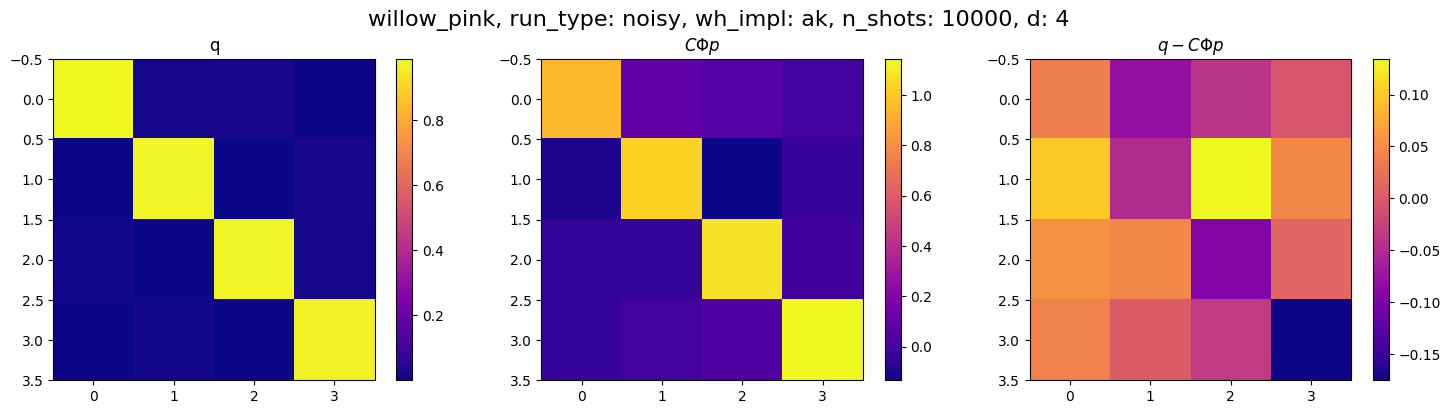

In [233]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
im1 = axes[0].imshow(q, cmap='plasma')
fig.colorbar(im1, ax=axes[0], label='')
axes[0].set_title('q')

im2 = axes[1].imshow(q_, cmap='plasma')
fig.colorbar(im2, ax=axes[1], label='')
axes[1].set_title(r'$C\Phi p$')

im3 = axes[2].imshow(q - q_, cmap='plasma')
fig.colorbar(im3, ax=axes[2], label='')
axes[2].set_title(r'$q - C\Phi p$')

fig.suptitle(context_str, fontsize=16)
plt.tight_layout()
fig.savefig("img/q_%s_%s_%d.pdf" % (query["run_type"], query["wh_implementation"], query["n_shots"]), bbox_inches='tight')
plt.show()